In [339]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn import preprocessing

#from sklearn.pipeline import Pipeline
#from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import BaggingRegressor, BaggingClassifier, RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.metrics import precision_score


In [2]:
'''
画图显示中文
'''
#-*- coding: utf-8 -*-
from matplotlib.font_manager import FontProperties
font = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=14)

In [375]:
#数据预处理
trainFile = r'E:\jupyter notebook\kaggle\titanic\titanic_data\train.csv'
pwd = os.getcwd()
os.chdir(os.path.dirname(trainFile))
trainSet = pd.read_csv(os.path.basename(trainFile), date_parser = True)
os.chdir(pwd)
trainSet[:6]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q


In [381]:
trainFile = r'E:\jupyter notebook\kaggle\titanic\titanic_data\test.csv'
pwd = os.getcwd()
os.chdir(os.path.dirname(trainFile))
testSet = pd.read_csv(os.path.basename(trainFile), date_parser = True)
os.chdir(pwd)


testSet.loc[testSet.Fare.isnull(), 'Fare'] = np.mean(testSet.Fare.notnull())
testSet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           418 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [382]:
#trainSet['Sex_Pclass'] = trainSet['Sex'] + '_' + trainSet['Pclass'].map(str)  #将性别和Pclass单独组合起来成为一个新的属性
testSet['Sex_Pclass'] = testSet['Sex'] + '_' + testSet['Pclass'].map(str)  #将性别和Pclass单独组合起来成为一个新的属性

In [383]:
def feature_extract(trainSet):
    import string, re
    def substrings_in_string(big_string, substrings):
        for substring in substrings:
            if big_string.find(substring) != -1:
                return substring
        print(big_string)
        return np.nan

    title_list=['Mrs', 'Mr', 'Master', 'Miss', 'Major', 'Rev',
                    'Dr', 'Ms', 'Mlle','Col', 'Capt', 'Mme', 'Countess',
                    'Don', 'Jonkheer']
    trainSet['Title']=trainSet['Name'].map(lambda x: substrings_in_string(x, title_list))

    def replace_titles(x):
            title=x['Title']
            if title in ['Mr','Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col']:
                return 'Mr'
            elif title in ['Master']:
                return 'Master'
            elif title in ['Countess', 'Mme','Mrs']:
                return 'Mrs'
            elif title in ['Mlle', 'Ms','Miss']:
                return 'Miss'
            elif title =='Dr':
                if x['Sex']=='Male':
                    return 'Mr'
                else:
                    return 'Mrs'
            elif title =='':
                if x['Sex']=='Male':
                    return 'Master'
                else:
                    return 'Miss'
            else:
                return title

    trainSet['Title'] = trainSet.apply(replace_titles, axis = 1)

    trainSet['AgeFill'] = trainSet['Age']
    mean_fill = np.zeros(4)
    mean_fill[0] = np.average(trainSet[trainSet['Title'] == 'Mr']['Age'].dropna())
    mean_fill[1] = np.average(trainSet[trainSet['Title'] == 'Mrs']['Age'].dropna())
    mean_fill[2] = np.average(trainSet[trainSet['Title'] == 'Miss']['Age'].dropna())
    mean_fill[3] = np.average(trainSet[trainSet['Title'] == 'Master']['Age'].dropna())

    trainSet.loc[ (trainSet.Age.isnull()) & (trainSet.Title == 'Mr') ,'AgeFill'] = mean_fill[0]
    trainSet.loc[ (trainSet.Age.isnull()) & (trainSet.Title == 'Mrs') ,'AgeFill'] = mean_fill[1]
    trainSet.loc[ (trainSet.Age.isnull()) & (trainSet.Title == 'Miss') ,'AgeFill'] = mean_fill[2]
    trainSet.loc[ (trainSet.Age.isnull()) & (trainSet.Title == 'Master') ,'AgeFill'] = mean_fill[3]

    trainSet['AgeCat'] = trainSet['AgeFill']
    trainSet.loc[(trainSet.AgeFill <= 12), 'AgeCat'] = 1
    #trainSet.loc[(trainSet.AgeFill > 10) & (trainSet.AgeFill <= 60), 'AgeCat'] = 'middle'
    #trainSet.loc[(trainSet.AgeFill > 30) & (trainSet.AgeFill <= 60), 'AgeCat'] = 'Senior'
    trainSet.loc[(trainSet.AgeFill > 12), 'AgeCat'] = 0

    trainSet.loc[trainSet.Embarked.isnull(), 'Embarked'] = 'S'
    #先去除这种操作试一试
    trainSet.loc[trainSet.Cabin.isnull(), 'Cabin'] = 0.5
    trainSet.loc[trainSet.Cabin.notnull(), 'Cabin'] = 1.5

    trainSet['family_size'] = trainSet.SibSp + trainSet.Parch
    #trainSet['family'] = trainSet.SibSp * trainSet.Parch
    
    trainSet['family_size'] = np.where(trainSet['family_size'] <= 3, 'Normal', 'Big')

    #trainSet['Fare_Per_Person']=trainSet['Fare']/(trainSet['family_size'] + 1)

    #Age times class
    #trainSet['AgeClass']=trainSet['AgeFill'] * trainSet['Pclass']
    #trainSet['ClassFare']=trainSet['Pclass'] * trainSet['Fare_Per_Person']

    #trainSet['HighLow']=trainSet['Pclass']
    #trainSet.loc[ (trainSet.Fare_Per_Person < 8) ,'HighLow'] = 'Low'
    #trainSet.loc[ (trainSet.Fare_Per_Person >= 8) ,'HighLow'] = 'High'

    le = preprocessing.LabelEncoder()
    '''
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    le.fit([1,5,67,100])
    le.transform([1,1,100,67,5])
    输出： array([0,0,3,2,1])
    '''
 
    le.fit(trainSet['Sex'] )
    x_sex=le.transform(trainSet['Sex'])
    trainSet['Sex']=x_sex.astype(np.float)
   
    le.fit( trainSet['Ticket'])
    x_Ticket=le.transform( trainSet['Ticket'])
    trainSet['Ticket']=x_Ticket.astype(np.float)
    
    le.fit(trainSet['family_size'])
    x_family =le.transform( trainSet['family_size'])
    trainSet['family_size'] = x_family.astype(np.float)


    le.fit(trainSet['Title'])
    x_title=le.transform(trainSet['Title'])
    trainSet['Title'] =x_title.astype(np.int)


    #le.fit(trainSet['HighLow'])
    #x_hl=le.transform(trainSet['HighLow'])
    #trainSet['HighLow']=x_hl.astype(np.float)


    le.fit(trainSet['AgeCat'])
    x_age=le.transform(trainSet['AgeCat'])
    trainSet['AgeCat'] =x_age.astype(np.float)

    le.fit(trainSet['Embarked'])
    x_emb=le.transform(trainSet['Embarked'])
    trainSet['Embarked']=x_emb.astype(np.float)
    
    #trainSet.loc[trainSet.Cabin.notnull(), 'Cabin'] = 'Yes'
    #trainSet.loc[trainSet.Cabin.isnull(), 'Cabin'] = 'No'

    
    return trainSet


trainSet = feature_extract(testSet)
'''
formula_ml='Survived~Pclass+C(Title)+Sex+C(AgeCat)+Fare_Per_Person+Fare+family_size' 

y_train, x_train = dmatrices(formula_ml, data=trainSet, return_type='dataframe')
y_train = np.asarray(y_train).ravel()

'''

"\nformula_ml='Survived~Pclass+C(Title)+Sex+C(AgeCat)+Fare_Per_Person+Fare+family_size' \n\ny_train, x_train = dmatrices(formula_ml, data=trainSet, return_type='dataframe')\ny_train = np.asarray(y_train).ravel()\n\n"

In [310]:
trainSet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 17 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null float64
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null float64
Fare           891 non-null float64
Cabin          891 non-null object
Embarked       891 non-null float64
Sex_Pclass     891 non-null object
Title          891 non-null int32
AgeFill        891 non-null float64
AgeCat         891 non-null float64
family_size    891 non-null float64
dtypes: float64(8), int32(1), int64(5), object(3)
memory usage: 114.9+ KB


In [384]:

dummies_Embarked = pd.get_dummies(trainSet['Embarked'], prefix= 'Embarked')

dummies_Sex = pd.get_dummies(trainSet['Sex'], prefix= 'Sex')

#dummies_Title_Pclass = pd.get_dummies(trainSet['Title_Pclass'], prefix= 'Title_Pclass')

#dummies_Cabin = pd.get_dummies(trainSet['Cabin'], prefix= 'Cabin')

dummies_Pclass = pd.get_dummies(trainSet['Pclass'], prefix= 'Pclass')

dummies_Sex_Pclass = pd.get_dummies(trainSet['Sex_Pclass'], prefix= 'Sex_Pclass')

#dummies_Title = pd.get_dummies(trainSet['Title'], prefix= 'Title')

#dummies_AgeCat = pd.get_dummies(trainSet['AgeCat'], prefix= 'AgeCat')

#dummies_HighLow = pd.get_dummies(trainSet['HighLow'], prefix= 'HighLow')

df = pd.concat([trainSet, dummies_Embarked, dummies_Sex, dummies_Pclass, dummies_Sex_Pclass], axis=1)
#df.drop(['Fare', 'Pclass', 'Sex',  'Embarked', 'Sex_Pclass', 'Title', 'AgeCat', 'HighLow'], axis=1, inplace=True)


#数据预处理，归一化
scaler = preprocessing.StandardScaler()
age_scaler = scaler.fit(np.array(df['AgeFill'].values.reshape(-1, 1)))
df['Age_scaled'] = age_scaler.transform(np.array(df['AgeFill'].values.reshape(-1, 1)))

fare_scaler = scaler.fit(np.array(df['Fare'].values.reshape(-1, 1)))
df['Fare_scaled'] = fare_scaler.transform(np.array(df['Fare'].values.reshape(-1, 1)))

'''
Fare_Per_Person_scaler = scaler.fit(np.array(df['Fare_Per_Person'].values.reshape(-1, 1)))
df['Fare_Per_Person_scaled'] = Fare_Per_Person_scaler.transform(np.array(df['Fare_Per_Person'].values.reshape(-1, 1)))

AgeClass_scaler = scaler.fit(np.array(df['AgeClass'].values.reshape(-1, 1)))
df['AgeClass_scaled'] = AgeClass_scaler.transform(np.array(df['AgeClass'].values.reshape(-1, 1)))

ClassFare_scaler = scaler.fit(np.array(df['ClassFare'].values.reshape(-1, 1)))
df['ClassFare_scaled'] = ClassFare_scaler.transform(np.array(df['ClassFare'].values.reshape(-1, 1)))

family_size_scaler = scaler.fit(np.array(df['family_size'].values.reshape(-1, 1)))
df['family_size_scaled'] = family_size_scaler.transform(np.array(df['family_size'].values.reshape(-1, 1)))

family_scaler = scaler.fit(np.array(df['family'].values.reshape(-1, 1)))
df['family_scaled'] = family_size_scaler.transform(np.array(df['family'].values.reshape(-1, 1)))
'''
df.drop(['Sex', 'Sex_Pclass', 'Pclass', 'Name', 'PassengerId', 'Age', 'Ticket', 'Fare'], axis=1, inplace=True)

In [312]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 25 columns):
Survived               891 non-null int64
SibSp                  891 non-null int64
Parch                  891 non-null int64
Cabin                  891 non-null object
Embarked               891 non-null float64
Title                  891 non-null int32
AgeFill                891 non-null float64
AgeCat                 891 non-null float64
family_size            891 non-null float64
Embarked_0.0           891 non-null uint8
Embarked_1.0           891 non-null uint8
Embarked_2.0           891 non-null uint8
Sex_0.0                891 non-null uint8
Sex_1.0                891 non-null uint8
Pclass_1               891 non-null uint8
Pclass_2               891 non-null uint8
Pclass_3               891 non-null uint8
Sex_Pclass_female_1    891 non-null uint8
Sex_Pclass_female_2    891 non-null uint8
Sex_Pclass_female_3    891 non-null uint8
Sex_Pclass_male_1      891 non-null uint8
Sex_

In [380]:
'''
trainSet_df = df.filter(regex='Survived|Cabin_.*|family_size|AgeClass_scaled|ClassFare_scaled|Embarked_.*|Sex_.*|Title_.*|\
                        Sex_Pclass_.*|HighLow_.*|Pclass_.*|AgeCat_.*|family_size_scaled||Fare_Per_Person_scaled')
'''

trainSet_df = df.filter(regex='Survived|Cabin|family_size|Embarked_.*\
                                |AgeCat|Sex_Pclass_.*|Title|Pclass_.*|Sex_.*|Age_scaled|Fare_scaled')
#'Survived~Pclass+C(Title)+Sex+C(AgeCat)+Fare_Per_Person+Fare+family_size' 

train_df = trainSet_df.as_matrix()

Y = train_df[:, 0].astype(int)
X = train_df[:, 1:]
#X = np.concatenate((X, X), axis = 0)
#Y = np.concatenate((Y, Y), axis = 0)


#bagging_clf = linear_model.LogisticRegression(penalty = 'l1' ,max_iter = 200, tol = 1e-6)
bagging_clf = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth = 1, subsample = 0.5,random_state=0, loss='ls')
#bagging_clf = RandomForestRegressor(n_estimators=20, random_state = 0, max_features='log2')
#bagging_clf = DecisionTreeRegressor(random_state = 0, max_depth = None)

#bagging_clf = svm.SVC()
bagging_clf = BaggingRegressor(bagging_clf, n_estimators=200, max_features=0.6, max_samples = 0.6)
    
bagging_clf.fit(X, Y)
#cross_val_score(bagging_clf, X, Y, cv=3)
#bagging_clf.fit(X, Y)
#clf.score(X, Y)

BaggingRegressor(base_estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=1, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=200, presort='auto', random_state=0,
             subsample=0.5, verbose=0, warm_start=False),
         bootstrap=True, bootstrap_features=False, max_features=0.6,
         max_samples=0.6, n_estimators=200, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [346]:
lr = LogisticRegression()
svc = SVC()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier(n_estimators=300,min_samples_leaf=4,class_weight={0:0.745,1:0.255})
gbdt = GradientBoostingClassifier(n_estimators=500,learning_rate=0.03,max_depth=3)

In [370]:
class Ensemble(object):
    
    def __init__(self,estimators):
        self.estimator_names = []
        self.estimators = []
        for i in estimators:
            self.estimator_names.append(i[0])
            self.estimators.append(i[1])
        self.clf = GradientBoostingClassifier()
    
    def fit(self, train_x, train_y):
        for i in self.estimators:
            i.fit(train_x,train_y)
        x = np.array([i.predict(train_x) for i in self.estimators]).T
        y = train_y
        self.clf.fit(x, y)
    
    def predict(self,x):
        x = np.array([i.predict(x) for i in self.estimators]).T
        #print(x)
        return self.clf.predict(x)
        
    
    def score(self,x,y):
        s = precision_score(y,self.predict(x))
        return s

In [371]:
bag = Ensemble([('dt', dt),('lr',lr),('rf',rf),('svc',svc),('gbdt',gbdt)])
score = 0
for i in range(0,10):
    num_test = 0.20
    X_train, X_cv, Y_train, Y_cv = train_test_split(X, Y, test_size=num_test)
    bag.fit(X_train, Y_train)
    #Y_test = bag.predict(X_test)
    acc_xgb = round(bag.score(X_cv, Y_cv) * 100, 2)
    score+=acc_xgb
print(score/10)  

72.3


In [356]:
testSet_df = df.filter(regex='Cabin|family_size|Embarked_.*\
                                |AgeCat|Sex_Pclass_.*|Title|Pclass_.*|Sex_.*|Age_scaled|Fare_scaled')
#'Survived~Pclass+C(Title)+Sex+C(AgeCat)+Fare_Per_Person+Fare+family_size' 

test_df = testSet_df.as_matrix()

In [362]:
bag.fit(X, Y)
pred = bag.predict(test_df)

In [363]:
pred

array([0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0,

In [372]:
from sklearn.model_selection import train_test_split

split_train, split_cv = train_test_split(trainSet_df, test_size=0.3, random_state=0)

train_cross = split_train
crossModel = bagging_clf.fit(train_cross.as_matrix()[:, 1:], train_cross.as_matrix()[:, 0].astype(int))

test_cross = split_cv
#crossModel.score(test_cross.as_matrix()[:, 1:], test_cross.as_matrix()[:, 0].astype(int))
mean_squared_error(test_cross.as_matrix()[:, 0].astype(int), crossModel.predict(test_cross.as_matrix()[:, 1:]))

0.11661338480984904

In [373]:
pred_X = bagging_clf.predict(X)
#Y = test_cross.as_matrix()[:, 0]
#pred_X = bagging_clf.predict(test_cross.as_matrix()[:, 1:])
pred_X[pred_X <= 0.5] = 0
pred_X[pred_X > 0.5] = 1
np.sum(pred_X == Y)/len(pred_X)

0.83726150392817056

In [188]:
#pd.DataFrame({"columns":list(trainSet_df.columns)[1:], "coef":list(crossModel.feature_importances_.T)})
pd.DataFrame({"columns":list(trainSet_df.columns)[1:], "coef":list(crossModel.coef_.T)})
#trainSet_df

AttributeError: 'BaggingRegressor' object has no attribute 'coef_'

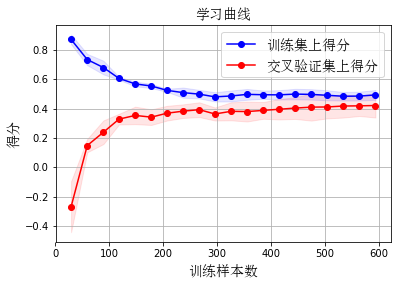

(0.43253397294333523, 0.18705784122661806)

In [128]:
from sklearn.learning_curve import learning_curve

# 用sklearn的learning_curve得到training_score和cv_score，使用matplotlib画出learning curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1, 
                        train_sizes=np.linspace(.05, 1., 20), verbose=0, plot=True):
    """
    画出data在某模型上的learning curve.
    参数解释
    ----------
    estimator : 你用的分类器。
    title : 表格的标题。
    X : 输入的feature，numpy类型
    y : 输入的target vector
    ylim : tuple格式的(ymin, ymax), 设定图像中纵坐标的最低点和最高点
    cv : 做cross-validation的时候，数据分成的份数，其中一份作为cv集，其余n-1份作为training(默认为3份)
    n_jobs : 并行的的任务数(默认1)
    """
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, verbose=verbose)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    if plot:
        plt.figure()
        plt.title(title, fontproperties = font)
        if ylim is not None:
            plt.ylim(*ylim)
        plt.xlabel(u"训练样本数", fontproperties = font)
        plt.ylabel(u"得分", fontproperties = font)
        plt.gca()
        plt.grid()

        plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, 
                         alpha=0.1, color="b")
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, 
                         alpha=0.1, color="r")
        plt.plot(train_sizes, train_scores_mean, 'o-', color="b", label=u"训练集上得分")
        plt.plot(train_sizes, test_scores_mean, 'o-', color="r", label=u"交叉验证集上得分")

        plt.legend(loc="best", prop = font)

        plt.draw()
        plt.show()

    midpoint = ((train_scores_mean[-1] + train_scores_std[-1]) + (test_scores_mean[-1] - test_scores_std[-1])) / 2
    diff = (train_scores_mean[-1] + train_scores_std[-1]) - (test_scores_mean[-1] - test_scores_std[-1])
    return midpoint, diff

plot_learning_curve(bagging_clf, u"学习曲线", X, Y)

In [390]:
testSet_df = df.filter(regex='Cabin|family_size|Embarked_.*\
                                |AgeCat|Sex_Pclass_.*|Title|Pclass_.*|Sex_.*|Age_scaled|Fare_scaled')
test_df = testSet_df.as_matrix()

pred_X = bagging_clf.predict(test_df)

pred_X[pred_X <= 0.5] = 0
pred_X[pred_X > 0.5] = 1

#将结果写进csv格式文件
result = pd.DataFrame({'PassengerId':testSet['PassengerId'].as_matrix(), 'Survived':pred_X.astype(int)})
result.to_csv(r"E:\jupyter notebook\kaggle\titanic\pred_label\predict.csv", index=False)

In [387]:
pred_X

152.0

In [389]:
arr

array([ 0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,
        0.,  1.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  0.,  1.,  0.,
        1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,
        0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,
        1.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,
        1.,  1.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,  1.,
        0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,
        0.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,
        1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  0.,  0.,
        1.,  1.,  1.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,
        1.,  1.,  0.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,
        1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  1.,  1.,  0

In [ ]:
0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,
        1.,  0.,  0.,  1.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,
        0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,
        0.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,  1.,
        0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,
        0.,  1.])